In [55]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import findspark
findspark.init()

In [56]:
import pyspark
from pyspark.sql import SparkSession
#import the maximum - max function
from pyspark.sql.functions import max

In [193]:
from sklearn.cluster import KMeans
from sklearn import datasets

In [57]:

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [84]:
# Liste des codes
codes = df[['Airport.Code']]
codes

,Airport.Code
0,ATL
1,BOS
2,BWI
3,CLT
4,DCA
...,...
4403,SAN
4404,SEA
4405,SFO
4406,SLC


In [183]:
path_repositories = "hdfs://localhost:9000/esgi/data/projets/planes/airlines2.csv"
sdf = spark.read.format('csv').options(delimiter=",", header=True).load(path_repositories)
df = sdf.select("*").toPandas()
#df.groupBy("Airport.Code").count().show()
df

,Airport.Code,Airport.Name,Time.Label,Time.Month,Time.Month Name,Time.Year,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,...,Statistics.Flights.Delayed,Statistics.Flights.Diverted,Statistics.Flights.On Time,Statistics.Flights.Total,Statistics.Minutes Delayed.Carrier,Statistics.Minutes Delayed.Late Aircraft,Statistics.Minutes Delayed.National Aviation System,Statistics.Minutes Delayed.Security,Statistics.Minutes Delayed.Total,Statistics.Minutes Delayed.Weather
0,ATL,Atlanta,GA: Hartsfield-Jackson Atlanta International,2003/06,6,June,2003,1009,1275,3217,...,Continental Air Lines Inc.,Delta Air Lines Inc.,Atlantic Southeast Airlines,AirTran Airways Corporation,America West Airlines Inc.,Northwest Airlines Inc.,ExpressJet Airlines Inc.,United Air Lines Inc.,US Airways Inc.,11
1,BOS,Boston,MA: Logan International,2003/06,6,June,2003,374,495,685,...,Continental Air Lines Inc.,Atlantic Coast Airlines,Delta Air Lines Inc.,Atlantic Southeast Airlines,AirTran Airways Corporation,America West Airlines Inc.,American Eagle Airlines Inc.,Northwest Airlines Inc.,ExpressJet Airlines Inc.,ATA Airlines d/b/a ATA
2,BWI,Baltimore,MD: Baltimore/Washington International Thurgo...,2003/06,6,June,2003,296,477,389,...,Delta Air Lines Inc.,AirTran Airways Corporation,America West Airlines Inc.,American Eagle Airlines Inc.,Northwest Airlines Inc.,ExpressJet Airlines Inc.,United Air Lines Inc.,US Airways Inc.,Southwest Airlines Co.,11
3,CLT,Charlotte,NC: Charlotte Douglas International,2003/06,6,June,2003,300,472,735,...,Atlantic Coast Airlines,Delta Air Lines Inc.,Atlantic Southeast Airlines,American Eagle Airlines Inc.,Northwest Airlines Inc.,ExpressJet Airlines Inc.,ATA Airlines d/b/a ATA,United Air Lines Inc.,US Airways Inc.,11
4,DCA,Washington,DC: Ronald Reagan Washington National,2003/06,6,June,2003,283,268,487,...,Continental Air Lines Inc.,Atlantic Coast Airlines,Delta Air Lines Inc.,Atlantic Southeast Airlines,America West Airlines Inc.,American Eagle Airlines Inc.,Northwest Airlines Inc.,ExpressJet Airlines Inc.,ATA Airlines d/b/a ATA,United Air Lines Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4403,SAN,San Diego,CA: San Diego International,2016/01,1,January,2016,280,397,171,...,JetBlue Airways,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,Spirit Air Lines,SkyWest Airlines Inc.,United Air Lines Inc.,Virgin America,Southwest Airlines Co.,11
4404,SEA,Seattle,WA: Seattle/Tacoma International,2016/01,1,January,2016,357,513,351,...,JetBlue Airways,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,SkyWest Airlines Inc.,United Air Lines Inc.,Virgin America,Southwest Airlines Co.,10,104
4405,SFO,San Francisco,CA: San Francisco International,2016/01,1,January,2016,560,947,2194,...,JetBlue Airways,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,SkyWest Airlines Inc.,United Air Lines Inc.,Virgin America,Southwest Airlines Co.,10,449
4406,SLC,Salt Lake City,UT: Salt Lake City International,2016/01,1,January,2016,338,540,253,...,JetBlue Airways,Delta Air Lines Inc.,Frontier Airlines Inc.,SkyWest Airlines Inc.,United Air Lines Inc.,Southwest Airlines Co.,8,84,1175,14


In [184]:
# Colonne pour compter le nombre de répétion sur month
codes = df[['Time.Month']]
codes = codes.groupby(by='Time.Month').size().reset_index(name='count')
codes

,Time.Month,count
0,2003/06,29
1,2003/07,29
2,2003/08,29
3,2003/09,29
4,2003/10,29
...,...,...
147,2015/09,29
148,2015/10,29
149,2015/11,29
150,2015/12,29


In [61]:
#Nous affichons ici le nombre de retards pour chaque aéroport
codes = df[['Airport.Name','Statistics.# of Delays.Late Aircraft']]
codes

,Airport.Name,Statistics.# of Delays.Late Aircraft
0,Atlanta,1009
1,Boston,374
2,Baltimore,296
3,Charlotte,300
4,Washington,283
...,...,...
4403,San Diego,280
4404,Seattle,357
4405,San Francisco,560
4406,Salt Lake City,338


In [148]:
# Les aéroports avec le plus de retard
codes = df[['Airport.Code','Airport.Name','Statistics.# of Delays.Late Aircraft']]
codes = codes.astype({"Statistics.# of Delays.Late Aircraft":'int64'})
codes = codes.groupby(['Airport.Code','Airport.Name']).sum().sort_values(by=['Statistics.# of Delays.Late Aircraft'],\
ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)\
codes

,,Statistics.# of Delays.Late Aircraft
Airport.Code,Airport.Name,
ATL,Atlanta,222813
ORD,Chicago,168436
LAX,Los Angeles,152974
DFW,Dallas/Fort Worth,142945
DEN,Denver,136305
PHX,Phoenix,114072
LAS,Las Vegas,101349
SFO,San Francisco,96879
IAH,Houston,91064


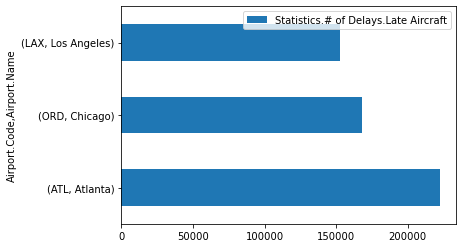

In [218]:
# Les 3 aéroports avec le plus de retard
codes = df[['Airport.Code','Airport.Name','Statistics.# of Delays.Late Aircraft']]
codes = codes.astype({"Statistics.# of Delays.Late Aircraft":'int64'})
codes = codes.groupby(['Airport.Code','Airport.Name']).sum().sort_values(by=['Statistics.# of Delays.Late Aircraft'],\
ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
codes.head(3).plot.barh();

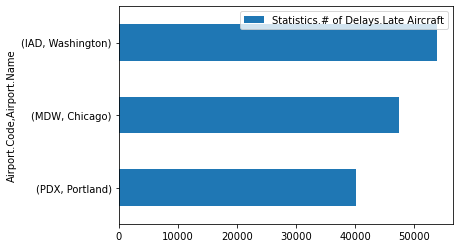

In [217]:
# Les 3 aéroports avec le moins de retard
codes = df[['Airport.Code','Airport.Name','Statistics.# of Delays.Late Aircraft']]
codes = codes.astype({"Statistics.# of Delays.Late Aircraft":'int64'})
codes = codes.groupby(['Airport.Code','Airport.Name']).sum().sort_values(by=['Statistics.# of Delays.Late Aircraft'],\
ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None).head(3)
codes.plot.barh();

In [187]:
# L'aéroport avec le plus de retard
codes = df[['Airport.Code','Airport.Name','Statistics.# of Delays.Late Aircraft']]
codes = codes.astype({"Statistics.# of Delays.Late Aircraft":'int64'})
codes = codes.groupby(['Airport.Code','Airport.Name']).sum().sort_values(by=['Statistics.# of Delays.Late Aircraft'],\
ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
codes.head(1)

,,Statistics.# of Delays.Late Aircraft
Airport.Code,Airport.Name,
ATL,Atlanta,222813


In [210]:
# On affiche pour chaque aéroport les 
codes = df[['Airport.Code','Airport.Name','Statistics.# of Delays.Carrier','Statistics.# of Delays.Late Aircraft','Statistics.# of Delays.National Aviation System','Statistics.# of Delays.Security','Statistics.# of Delays.Weather']]
codes = codes.astype({"Statistics.# of Delays.Late Aircraft":'int64'})
codes = codes.groupby(['Airport.Code','Airport.Name']).sum().sort_values(by=['Statistics.# of Delays.Late Aircraft'],\
ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)


In [223]:
codes = df[['Airport.Code','Airport.Name','Statistics.# of Delays.Late Aircraft','Time.Month']]
codes.loc[df['Airport.Code']=='ATL']

,Airport.Code,Airport.Name,Statistics.# of Delays.Late Aircraft,Time.Month
0,ATL,Atlanta,1009,2003/06
29,ATL,Atlanta,1259,2003/07
58,ATL,Atlanta,1220,2003/08
87,ATL,Atlanta,700,2003/09
116,ATL,Atlanta,756,2003/10
...,...,...,...,...
4263,ATL,Atlanta,945,2015/09
4292,ATL,Atlanta,1021,2015/10
4321,ATL,Atlanta,1112,2015/11
4350,ATL,Atlanta,1529,2015/12
